# Transport patterns between curves
The goal of this notebook is to visualize transport patterns between
curves; it appears that the linear program may be the bottleneck of
the implementation, so we're going to see if we can write a more efficient
implementation here.

First, we'll define some curves.

In [1]:
# imports
import numpy as np
import numpy.linalg as la
import scipy.optimize as op
import seaborn as sns; sns.set()

%matplotlib inline

## Define (and plot) the line segments

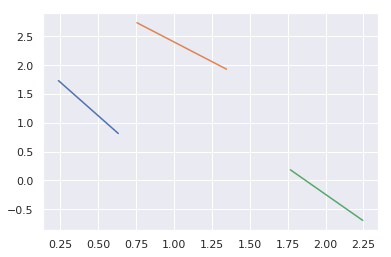

In [34]:
def line_segment(start, vec, seglen, n_pts):
    p0 = np.array(start)
    v = np.array(vec)
    v = v / la.norm(v) * seglen / n_pts
    return np.array([p0+k*v for k in range(n_pts+1)])

def random_uniform_direction():
    theta = np.random.uniform(0, 2*np.pi)
    return [np.cos(theta), np.sin(theta)]

N_DIV = 40
N_CURVE = 3
RMAX = 2.
curves = [
    line_segment(np.random.uniform(0, RMAX, size=2), 
                 random_uniform_direction(), 1, N_DIV-1),
    line_segment(np.random.uniform(0, RMAX, size=2), 
                 random_uniform_direction(), 1, N_DIV-1),
    line_segment(np.random.uniform(0, RMAX, size=2), 
                 random_uniform_direction(), 1, N_DIV-1)
]
#curves = [
#    line_segment((0,1), 
#                 (0.001,1), 1, N_DIV-1),
#    line_segment((1,0), 
#                 (1,0), 1, N_DIV-1),
#    line_segment((2,3), 
#                 (1,-1), 1, N_DIV-1)
#]

for curve in curves:
    sns.lineplot(*curve.T, antialiased=True)
    #sns.scatterplot(*curve.T, antialiased=True)

## Geometric median function

In [35]:
# Geometric median
import numpy as np
from scipy.spatial.distance import cdist, euclidean
import numpy.linalg as la

def geometric_median(X, eps=1e-5, max_iter=1000):
    y = np.mean(X, 0)

    for _ in range(max_iter):
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1
    return y

th60 = np.radians(60)
c60, s60 = np.cos(th60), np.sin(th60)
rot60 = np.array([[c60,-s60],[s60,c60]])
rotN60 = np.array([[c60,s60],[-s60,c60]])

def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

def geometric_median_3(X, **kwargs):
    """Use geometry to compute fast explicit GM of 3 points"""
    A,B,C = X
    
    ABvec = B-A
    ACvec = C-A
    if (np.arctan2(ACvec[1], ACvec[0]) - np.arctan2(ABvec[1], ABvec[0])) > 0:
        B,C = C,B
        ABvec = B-A
        ACvec = C-A
    
    ARvec = rot60 @ ABvec
    R = X[0]+ARvec
    
    AQvec = rotN60 @ ACvec
    Q = X[0]+AQvec
    
    P = get_intersect(R,X[2],Q,X[1])
    
    S = [A,B,C,P]
    d = [sum(la.norm(z-fp) for z in X) for fp in S]
    
    return S[np.argmin(d)]
    

## Set up the linear program

In [36]:
N = len(curves[0])
np.ones((N,1)) @ curves[0][:,[0]].T

array([[0.23670842, 0.24683681, 0.2569652 , ..., 0.61145894, 0.62158733,
        0.63171573],
       [0.23670842, 0.24683681, 0.2569652 , ..., 0.61145894, 0.62158733,
        0.63171573],
       [0.23670842, 0.24683681, 0.2569652 , ..., 0.61145894, 0.62158733,
        0.63171573],
       ...,
       [0.23670842, 0.24683681, 0.2569652 , ..., 0.61145894, 0.62158733,
        0.63171573],
       [0.23670842, 0.24683681, 0.2569652 , ..., 0.61145894, 0.62158733,
        0.63171573],
       [0.23670842, 0.24683681, 0.2569652 , ..., 0.61145894, 0.62158733,
        0.63171573]])

In [37]:
#%%timeit

# Specific 3-group case
groups = []
for i0, A in enumerate(curves[0]):    
    for i1, B in enumerate(curves[1]):
        ABvec = B-A
        ARvec = rot60 @ ABvec
        
        for i2, C in enumerate(curves[2]):
            ACvec = C-A
            AQvec = rotN60 @ ACvec
            
            tan_phi = np.arctan2(ACvec[1], ACvec[0]) - np.arctan2(ABvec[1], ABvec[0]) 
            if (tan_phi) < 0:
                R = A + ARvec
                Q = A + AQvec
            else:      
                R = B - ARvec
                Q = C - AQvec

            P = get_intersect(R,C,Q,B)

            S = [A,B,C,P]
            energy = [sum(la.norm(z-fp) for z in [A,B,C]) for fp in S]
            m_i = np.argmin(energy)

            groups.append({
                'index': [i0, i1, i2],
                'points': np.array([A,B,C]),
                'median': S[m_i],
                'energy': energy[m_i],
            })

In [38]:
medians = np.array([g['median'] for g in groups])

We now move on to setting up (and solving) the linear program proper. Scipy's linprog uses the following form for linear programs. We are solving for \\(x\\) which minimizes
\\[ c^T x \\]
while satisfying the constraints
\\[ A_{ub} x \le b_{ub}, \quad A_{eq} x = b_{eq}, \quad l \le x \le u \\]

In our case, the cost we're minimizing is the linear combination of total median distances

In [39]:
# group energies (c-vector)
energies = np.array([g['energy'] for g in groups])

In [40]:
def _idxs(index):
    return [i*N_DIV+j for i,j in enumerate(index)]

import scipy.sparse as sparse

# equality constraints
A_eq = sparse.dok_matrix((N_DIV*N_CURVE, len(energies)))
for i,g in enumerate(groups):
    A_eq[_idxs(g['index']), i] = 1.
    
# transport quantities are all 1 for uniform problem
b_eq = np.ones(A_eq.shape[0])

In [41]:
A_eq.shape

(120, 64000)

In [42]:
from scipy.optimize import linprog
soln = linprog(energies, A_eq=A_eq, b_eq=b_eq, method='interior-point')

/home/harrison/.local/lib/python3.6/site-packages/scipy/optimize/_linprog_ip.py:2050: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  OptimizeWarning)
/home/harrison/.local/lib/python3.6/site-packages/scipy/optimize/_linprog_ip.py:623: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning)


In [43]:
import pandas as pd
solution = pd.DataFrame([
    {'weight': x, 
     'median_x': group['median'][0], 
     'median_y': group['median'][1],
     't_0': group['index'][0],
     't_1': group['index'][1],
     't_2': group['index'][2]} for 
    x,group in zip(soln['x'], groups)])

print(len(solution[solution['weight'] > 0.001]), "median points")
solution[solution['weight'] > 0.001].sort_values('t_2')

84 median points


,median_x,median_y,t_0,t_1,t_2,weight
7720,0.507836,1.681127,4,33,0,1.000000
9281,0.521663,1.658118,5,32,1,0.999999
29482,0.757108,1.370295,18,17,2,0.499988
3082,0.440453,1.745210,1,37,2,0.500011
23283,0.675957,1.457462,14,22,3,0.499999
13963,0.565115,1.589828,8,29,3,0.500000
24844,0.689747,1.434408,15,21,4,0.500000
15524,0.578932,1.566808,9,28,4,0.499998
1565,0.402655,1.763952,0,39,5,0.750006
18645,0.608575,1.521546,11,26,5,0.249994


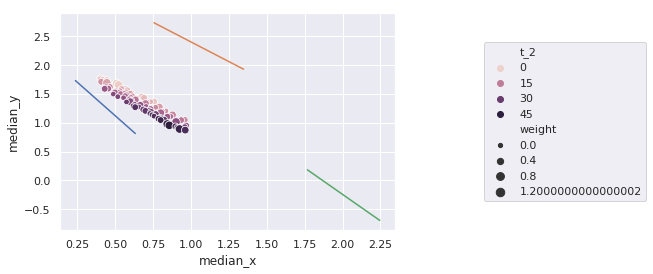

In [44]:
for curve in curves:
    sns.lineplot(*curve.T, antialiased=True)
    #sns.scatterplot(*curve.T, antialiased=True)
    
g = sns.scatterplot(data=solution[solution['weight'] > 1e-3], 
                x='median_x', y='median_y',
                hue='t_2', size='weight', size_norm=(0,1))
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

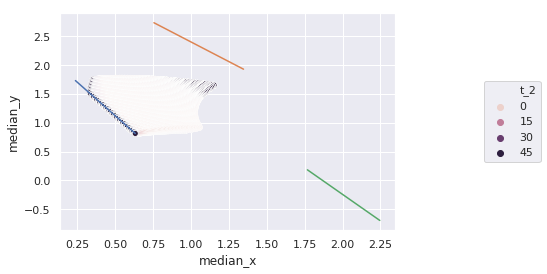

In [45]:
for curve in curves:
    sns.lineplot(*curve.T, antialiased=True)
    #sns.scatterplot(*curve.T, antialiased=True)
    
g = sns.scatterplot(data=solution, 
                x='median_x', y='median_y',
                hue='t_2')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

In [ ]:
sns.scatterplo